# # Project: Investigate a Dataset - [Soccer Database](https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a0a4cad_database/database.sqlite)
###### Lucas de Lima, 8/25/22
---
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#question 1">First Question</a></li>
<li><a href="#findings question 1">Answering First Question</a></li>
<li><a href="#question 2">Second Question</a></li>
<li><a href="#findings question 2">Answering Second Question</a></li> 
<li><a href="#question 3">Third Question</a></li>
<li><a href="#findings question 3">Answering Third Question</a></li> 
<li><a href="#question 4">Fourth Question</a></li>
<li><a href="#findings question 4">Answering Fourth Question</a></li> 
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

Our database is a big collection of information from 11 Countries and their respective National Leagues. Namely:
* Belgium 
* England 
* France 
* Germany 
* Italy 
* Netherlands 
* Poland 
* Portugal 
* Scotland 
* Spain
* Switzerland

Under which we have 7 tables with datasets that we used:

1. Country (id and name)
2. League (id, country_id and name)
3. Match (id, league_id, season, home_team_api_id, away_team_api_id, home_team_goals and away_team_goals)
4. Player (player_name, player_fifa_api_id, birthday)
5. Player_attributes (player_fifa_id, potential, overall_rating, date)
6. Team (team_fifa_api_id, team_long_name)
7. Team_attributes (team_fifa_api_id, date, buildupplayspeed, buildupplaydribbling, buildupplaypassing, chancecreationpassing, chancecreationcrossing, defencepressure, defenceagression and defenceteamwidth)

All the tables were interconnected via fifa_api_id's for players and teams or just regular id's for countries and leagues.
    
After skimming through and checking the consistency of data, I opted to not use many columns that had little meaning or that had unvalid value inputs. Then, i proceeded to think about the questions i could ask and answer with the available data 
i had on hands. Some that came to mind:


### Question(s) for Analysis

1. How much, if at all, does a players rating decrease with his age?
2. Does a "home field" advantage really translate to more odds of winning games at home?
3. Which leagues had higher goals overall and averaged per game?
4. What is the correlation between the average stats of a team and its chances of winning more games during a season?

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [14]:
# Upgrade pandas to use dataframe.explode() function. 
#!pip install --upgrade pandas==0.25.0

# <a id='question 1'></a>
## Question 1: How much, if at all, does a players rating decrease with age?
---


For analyzing players and their associated ratings i inner joined the Player and Player_attributes tables, retrieved their names, rating, potential rating, DOB and date of inserted data. One common factor in this report is that i will be formatting the dates for my needs, here i don't actually need their current age, just need the progression from each year to compare
with their ratings, so i shall eventually drop all the characters from birthday and date columns
except for the first 4, which correspond to the Year. fifa_api_id in this dataset was exactred
directly from the Fifa soccer games along with the player ratings. fifa_api_id was also used
to join the tables but don't hold actual value for us, so i decided to leave it out of the
queried data.

### SQL code for players and ratings

select P.player_name as "name", PA.overall_rating as "rating", 

 PA.potential as "potential", P.birthday as "birthday", PA.date as "date"  
 
from Player as P 

inner join Player_Attributes as PA 

on P.player_fifa_api_id = PA.player_fifa_api_id 

Order By P.player_name;


Then exported as Players_and_ratings.csv

In [115]:
#Player Ratings loading data
PRdf = pd.read_csv('Players_and_ratings.csv')

In [121]:
#dropping extra characters in birthday and date, then calculating age and dropping duplicates and null
PRdf['birthday'] = PRdf['birthday'].str[:4]
PRdf['date'] = PRdf['date'].str[:4]
PRdf['age'] = PRdf['date'].astype(int) - PRdf['birthday'].astype(int)
PRdf.drop_duplicates(inplace=True)
PRdf.dropna(inplace=True)
PRdf.head()

,name,rating,potential,birthday,date,age
0,Aaron Appindangoye,67.0,71.0,1992,2016,24
1,Aaron Appindangoye,67.0,71.0,1992,2015,23
2,Aaron Appindangoye,62.0,66.0,1992,2015,23
3,Aaron Appindangoye,61.0,65.0,1992,2015,23
4,Aaron Appindangoye,61.0,65.0,1992,2007,15


<AxesSubplot:>

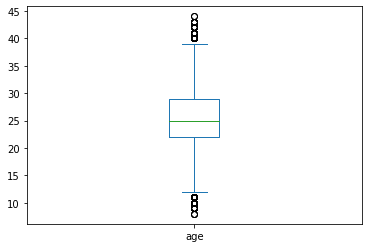

In [117]:
#plotting box to identify outliers (i.e kids and very old players)
PRdf['age'].plot.box()

In [106]:
PRdf['age'].describe()

count    124920.000000
mean         25.398711
std           4.801278
min           8.000000
25%          22.000000
50%          25.000000
75%          29.000000
max          44.000000
Name: age, dtype: float64

In [107]:
#dropping outliers, considering my lower limit as adult age instead of 25% - 1.5(box size)
#upper limit = 75% + 1.5(box size) = 29 + 1.5*7 = 39.5 and storing in a New Dataframe, to keep original intact
PRA = PRdf.query('age > 18')
PRA = PRA.query('age < 40')

In [108]:
#mean values of rating per age group
PRA = PRA.groupby('age')['rating'].mean()

In [186]:
#checking how long players, on average, played. Y = years
#creating player rating years min 
PRYmin = PRdf.groupby('name').min()
PRYmin.pop('potential')
PRYmin.pop('birthday')
PRYmin.pop('rating')
PRYmin.pop('date');

In [191]:
#creating player rating years max
PRYmax = PRdf.groupby('name').max()
PRYmax.pop('potential')
PRYmax.pop('birthday')
PRYmax.pop('date')
PRYmax.rename(columns ={'age':'age_old'},inplace=True)

In [192]:
#creating dataframe with age differnece
PRY = pd.concat([PRYmax,PRYmin],axis=1,join='inner')
PRY['years_played'] = PRY['age_old']-PRY['age']

In [198]:
PRY['years_played'].mean()

7.724926253687316

In [221]:
#querying into 2 df's players who played longer or shorter than the average
short= PRY.query('years_played < 7.724926253687316')
long = PRY.query('years_played > 7.724926253687316')
short.pop('age_old')
short.pop('age')
long.pop('age_old')
long.pop('age');

In [232]:
#quick sorting
long = long.sort_values(by='years_played')
short = short.sort_values(by='years_played')

# <a id='findings question 1'></a>
## Analyzing our data
---

So, now that our data is ready, lets take a look at how the average rating evolves according to a players age.

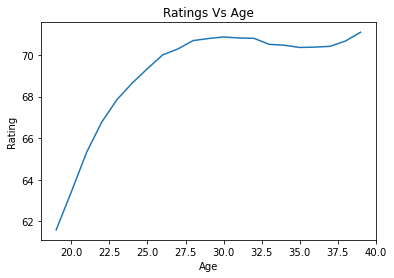

In [266]:
PRA.plot.line(title="Ratings Vs Age",xlabel="Age",ylabel="Rating");

So according to our data, players tend to improve their ratings as they age! At a fast rate during their early 20's and eventually still improving into their 40's.

But wait, that doesn't seem to make much sense. Aren't players supposed to get worse as they age?
Lets take a look at the distribution of age samples!

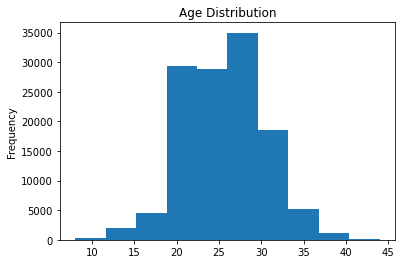

In [113]:
PRdf['age'].plot.hist(title="Age Distribution",xlabel="Age");

As we can see in our Distribution of Age Samples, we have very few players over the age of 35. Therefore, a possible explanation to our initial question is that the lower rated players just simply phase out of competitive Soccer before they have the chance to lower the average rating of higher aged players! 

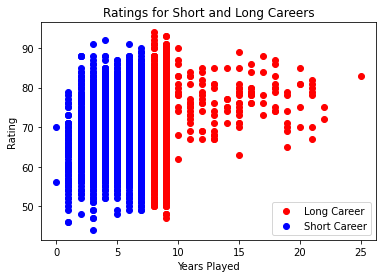

In [257]:
fig, LxS = plt.subplots()
LxS.scatter(long['years_played'], long['rating'], color='red', label="Long Career")
LxS.scatter(short['years_played'], short['rating'], color='blue', label="Short Career")

plt.legend(loc="lower right")
plt.title("Ratings for Short and Long Careers")
plt.xlabel("Years Played")
plt.ylabel("Rating")
plt.show()

Voilà! Now that explains our initial findings. As we can tell by this scatter plot, players with over 10 years playing tend to only continue if their Rating is fairly high, around 70 and over!

# <a id='question 2'></a>
## Question 2: Does a "home field" advantage really translate to more odds of winning games at home?
---

From the Match table I want to acquire the teams playing home and away and how many goals scored. 
Since the Match table had api numbers i had to inner join League and left join Team twice, once for Home and
once for Away. (side note: There probably was an easier way to accomplish this, but my inexperience said this was the way to go.)

### SQL code for league
select L.name as "league_name", M.season as "season", M.date as "date",

 T1.team_long_name as "home", T2.team_long_name as "away",
 
 M.home_team_goal as "home_goals", M.away_team_goal as "away_goals"
 
from Match as M

inner join League as L

on M.league_id = L.id

left join Team as T1

on M.home_team_api_id = T1.team_api_id

left join Team as T2

on M.away_team_api_id = T2.team_api_id

Then extracted as Leagues.csv

In [747]:
#Reading the csv and checking how everything looks
Leagues = pd.read_csv('Leagues.csv')
Leagues.head()

,league_name,season,date,home,away,home_goals,away_goals
0,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1
1,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0
4,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3


In [284]:
#checking to see if we have any null values
Leagues.isnull().sum()

league_name    0
season         0
date           0
home           0
away           0
home_goals     0
away_goals     0
dtype: int64

In [269]:
#For this question we shall store query results into a new data frame for all the home games won and lost or tied
HW = Leagues.query('home_goals > away_goals')
HL = Leagues.query('home_goals < away_goals')
HT = Leagues.query('home_goals == away_goals')

In [270]:
#Looking good
HW.head()

,league_name,season,date,home,away,home_goals,away_goals
3,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0
8,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,KVC Westerlo,Sporting Charleroi,1,0
9,Belgium Jupiler League,2008/2009,2008-11-01 00:00:00,Club Brugge KV,KV Kortrijk,4,1
21,Belgium Jupiler League,2008/2009,2008-11-07 00:00:00,KSV Cercle Brugge,SV Zulte-Waregem,2,0
25,Belgium Jupiler League,2008/2009,2008-11-08 00:00:00,KVC Westerlo,KRC Genk,1,0


In [294]:
#Creating Variables for plotting
ProcentW = len(HW)/len(Leagues)
ProcentL = len(HL)/len(Leagues)
ProcentT = len(HT)/len(Leagues)
odds = [ProcentW,ProcentL,ProcentT]
labels = 'Home Wins','Home Losses','Ties'

# <a id='findings question 2'></a>
## Analyzing our data 2
---

One would think that playing at home, with the support of your crowd, you would play better and win more often. Does that really occur?

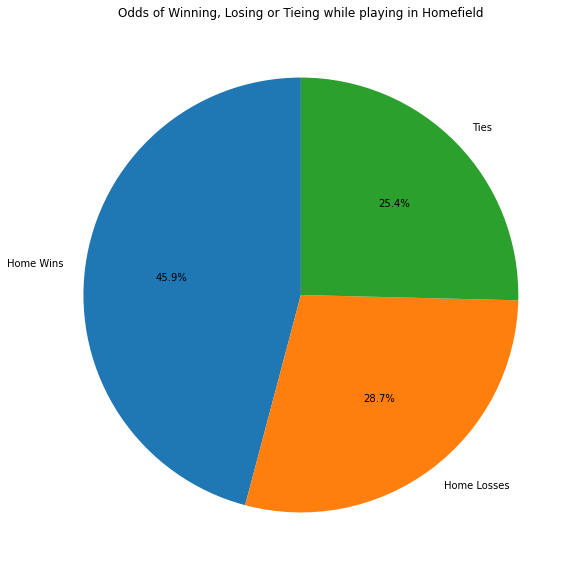

In [302]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(odds,labels=labels,autopct='%1.1f%%',startangle=90)
plt.title("Odds of Winning, Losing or Tieing while playing in Homefield")
plt.show()

Therefore, the team with the Home Field advantage Won very often (slightly under 50% at 45.9%).

# <a id='question 3'></a>
## Question 3: Which leagues had higher goals overall and averaged per game?
---

For this question we shall use the same dataset as question 2

In [303]:
Leagues.head()

,league_name,season,date,home,away,home_goals,away_goals
0,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1
1,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0
4,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3


In [333]:
#passing to new df, grouping by the league name and summing goals, finally sorting
Total_goals = Leagues.groupby('league_name').sum()
Total_goals['total'] = Total_goals['home_goals'] + Total_goals['away_goals']
Total_goals.pop('home_goals')
Total_goals.pop('away_goals')
Total_goals.sort_values(by='total',inplace=True)

In [325]:
#now to count amount of games per league and append that to a different dataset with total amount of goals
Amount_matches = Leagues.groupby('league_name').count()['date']

In [338]:
#Appending the 2 datasets, creating the average column
Average_goals = pd.merge(Total_goals,Amount_matches,on='league_name',how="left")
Average_goals.rename(columns={'date':'matches'},inplace=True)
Average_goals['avg'] = Average_goals['total']/Average_goals['matches']
Average_goals.pop('matches')
Average_goals.pop('total')
Average_goals.sort_values(by='avg',inplace=True)

# <a id='findings question 3'></a>
## Analyzing our data 3
---

Although we have data from 11 National Leagues, there are obviously a couple well know that stand out for being better known, such as Englands Premier League. But, which league has the highest scoring average and which has the highest amount of goals in our dataset?

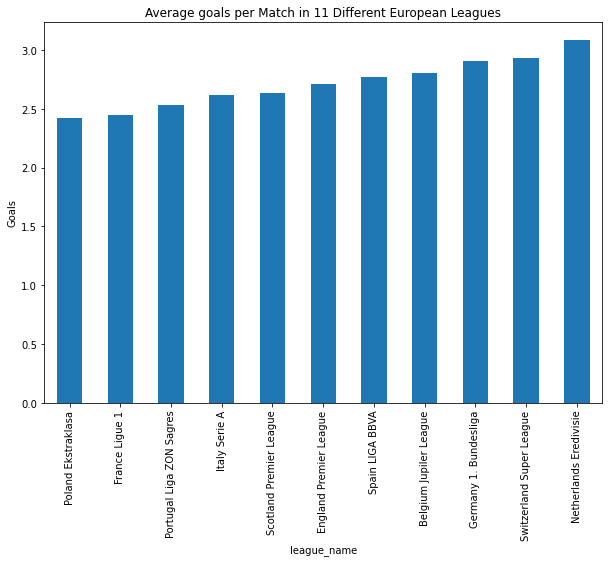

In [356]:
Average_goals.plot.bar(figsize=(10,7),legend=False,\
                       title="Average goals per Match in 11 Different European Leagues",ylabel="Goals");

So the Eredvisie from the Netherlands has the highest scoring average.

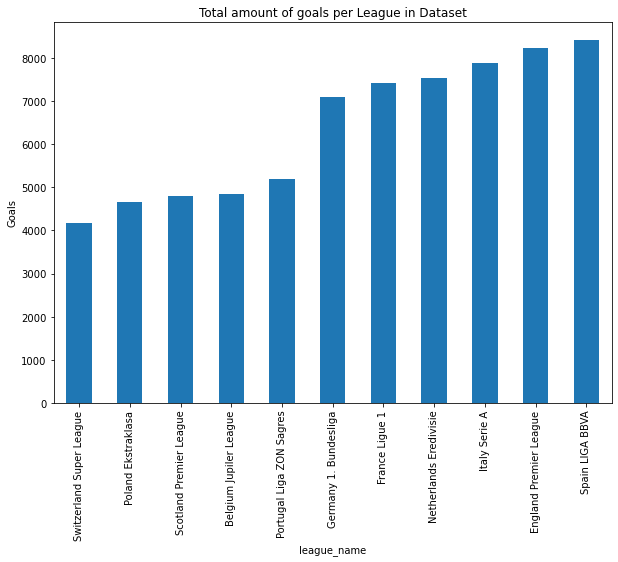

In [358]:
Total_goals.plot.bar(figsize=(10,7),title="Total amount of goals per League in Dataset",legend=False,ylabel="Goals");

And the Spanish LIGA BBVA has the most amount of goals recorded in this dataset!

# <a id='question 4'></a>
## Question 4: What is the correlation between the average stats of a team and its chances of winning more games during a season?
---

For this question we shall extract the Team information and compare it with the Match information earlier extracted

For teams and their ratings, basically similar extraction process as players, except that here
we have multiple ratings. I am going to modify the date slightly different, since for the questions
relating to teams I shall be using Seasons instead of years.

SQL query for Teams and ratings
select T.team_long_name as "team_name",

 TA.buildUpPlayDribbling as "dribbling", TA.buildUpPlaySpeed as "play_speed", 
 
 TA.buildUpPlayPassing as "passing", TA.chanceCreationCrossing as "crossing_creation" ,
 
 TA.chanceCreationPassing as "passing_creation", TA.chanceCreationShooting as "shooting_creation",
 
 TA.defenceAggression as "def_agression", TA.defencePressure "def_pressure", TA.defenceTeamWidth as "def_width",
 
 TA.date as "date"

from Team as T

inner join Team_Attributes as TA

on T.team_fifa_api_id = TA.team_fifa_api_id

Order By T.team_long_name;

Then extracted as Teams_and_ratings.csv

In [663]:
#Loading and viewing
Teams = pd.read_csv('Teams_and_ratings.csv')
Teams.head()

,team_name,dribbling,play_speed,passing,crossing_creation,passing_creation,shooting_creation,def_agression,def_pressure,def_width,date
0,1. FC Kaiserslautern,NaN,45,55,70,45,70,70,70,70,2010-02-22 00:00:00
1,1. FC Kaiserslautern,NaN,48,42,68,49,53,48,38,53,2011-02-22 00:00:00
2,1. FC Kaiserslautern,NaN,38,54,49,43,64,51,37,53,2012-02-22 00:00:00
3,1. FC Kaiserslautern,NaN,61,54,62,43,56,50,48,53,2013-09-20 00:00:00
4,1. FC Kaiserslautern,48.0,66,53,69,54,51,47,47,49,2014-09-19 00:00:00


In [664]:
#creating a column to give us the average rating and dropping others
Teams.fillna(0,inplace=True)
Teams['avg'] = (Teams.dribbling + Teams.play_speed + Teams.passing + Teams.crossing_creation + Teams.passing_creation \
+ Teams.shooting_creation + Teams.def_agression + Teams.def_pressure + Teams.def_width) / 9
Teams.drop(Teams.columns[[1,2,3,4,5,6,7,8,9]],axis=1,inplace=True)

In [671]:
#creating a function to convert our date to season and removing date afterwards
def season(x):
    if x=="2010-02-22 00:00:00":
        return 2010
    elif x=="2011-02-22 00:00:00":
        return 2011
    elif x=="2012-02-22 00:00:00":
        return 2012
    elif x=="2013-09-20 00:00:00":
        return 2013
    elif x=="2014-09-19 00:00:00":
        return 2014
    else:
        return 2015
    

Teams['season']= Teams['date'].apply(season)
Teams.pop('date');

In [748]:
#burner df to not mix up the original, fixing the season and poppin date
League = Leagues
League['season'] = League['season'].str[5:]
League.pop('date')
League.head()

,league_name,season,home,away,home_goals,away_goals
0,Belgium Jupiler League,2009,KRC Genk,Beerschot AC,1,1
1,Belgium Jupiler League,2009,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium Jupiler League,2009,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium Jupiler League,2009,KAA Gent,RAEC Mons,5,0
4,Belgium Jupiler League,2009,FCV Dender EH,Standard de Liège,1,3


In [749]:
#create function to assign a 1 for a win and apply for home or away win, then popping the goals
def win_or_lose(x,y):
    if x>y:
        return 1
    else:
        return 0
    
League['home_win'] = League.apply(lambda x: win_or_lose(x['home_goals'], x['away_goals']), axis=1)
League['away_win'] = League.apply(lambda x: win_or_lose(x['away_goals'], x['home_goals']), axis=1)
League.pop('home_goals')
League.pop('away_goals');

In [750]:
#filtering League to have only seasons 2010:2015
League = League.query('"2009" < season < "2016"')

In [785]:
#grouping 
Wins = League.groupby(['home','season'])['home_win'].sum() + League.groupby(['away','season'])['away_win'].sum()
Win = Wins.to_frame(name ='wins').reset_index()
Win.rename(columns={"home":"team_name"},inplace=True)

In [798]:
Teams['season']= Teams['season'].astype(str)
#to make the join easier, going to create a column called name_and_season
Teams['name_and_season'] = Teams.team_name + Teams.season
Win['name_and_season'] = Win.team_name + Win.season

In [809]:
#Merging and getting rid of everything except team name, avg, season and wins, renaming to look better
Final = pd.merge(Teams,Win,on='name_and_season',how="inner")
Final.drop(columns=['team_name_y','season_y','name_and_season'],inplace=True)
Final.rename(columns={'team_name_x':'team_name','season_x':'season'},inplace=True)

In [835]:
#Time to create some df's to plot
Final.sort_values(by='avg',ascending=False,inplace=True)
Final20=Final.head(20)

In [876]:
#2010 season with sample 20
Final10 = Final.query('season == "2010"')
Final10 = Final10.sample(20).sort_values(by='avg')

In [878]:
#2015 season with sample 20
Final15 = Final.query('season == "2015"')
Final15 = Final10.sample(20).sort_values(by='avg')

# <a id='findings question 4'></a>
## Analyzing our data 4
---

We can now look at an overall view of the teams wins during a season compared to their average overall Ratings!

For our first look we shall plot the 20 Teams with highest Average Ratings across all season from our data.

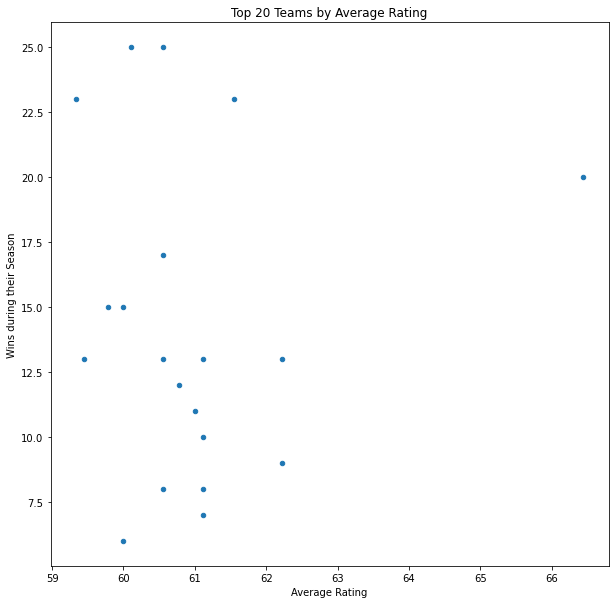

In [875]:
Final20.plot.scatter('avg','wins',figsize=(10,10),\
                title="Top 20 Teams by Average Rating",xlabel="Average Rating",ylabel="Wins during their Season");

It doesn't appear to show a direct correlation between higher ratings and more wins during a season, especially noteworthy the points at around (60,3) and (61,25).


Next, we shall analyze two separate seasons, 2010 and 2015, chosen randomly and extracting a random sample of size 20, to see if this no-correlation trend continues.

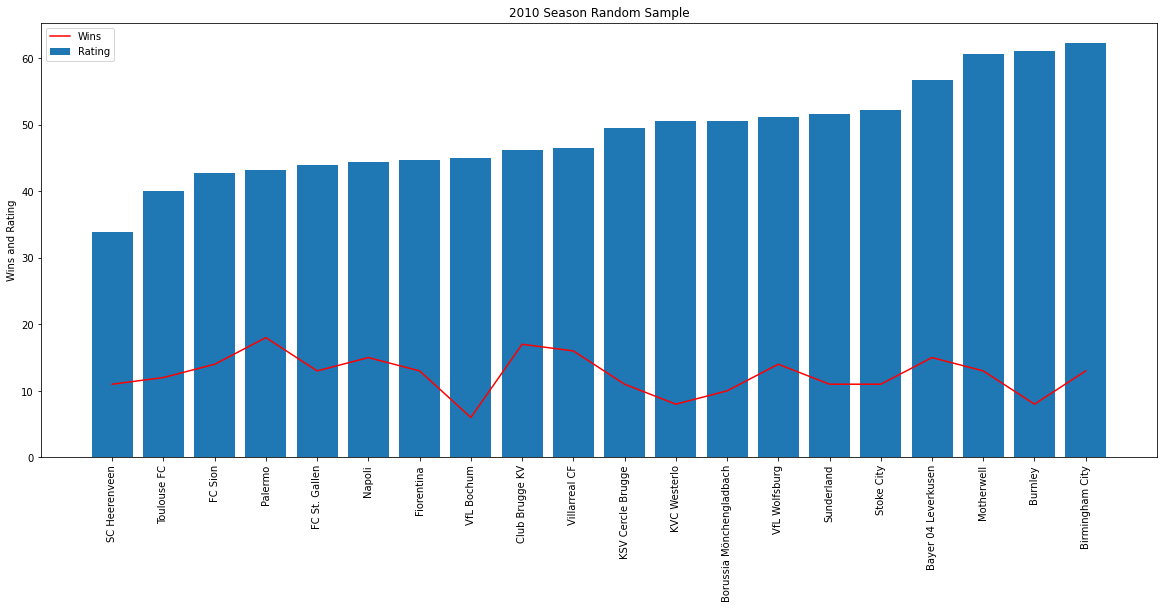

In [902]:
plt.bar(Final10['team_name'],Final10['avg'])
plt.plot(Final10['team_name'],Final10['wins'],color='red')
plt.xticks(rotation=90)
plt.title("2010 Season Random Sample")
plt.ylabel("Wins and Rating")
plt.legend(['Wins','Rating'])
plt.rcParams["figure.figsize"] = (20,6)
plt.show()

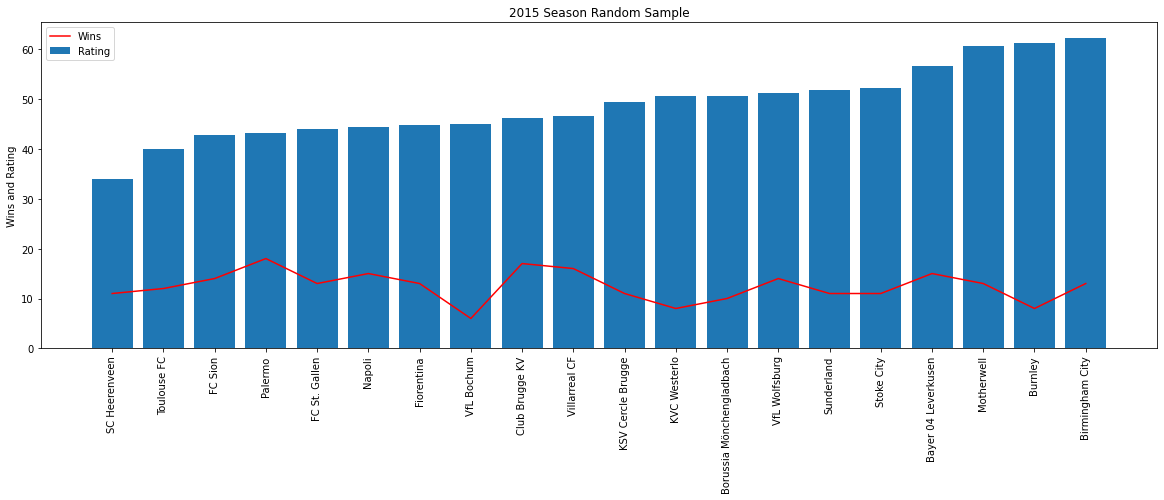

In [903]:
plt.bar(Final15['team_name'],Final15['avg'])
plt.plot(Final15['team_name'],Final15['wins'],color='red')
plt.xticks(rotation=90)
plt.title("2015 Season Random Sample")
plt.ylabel("Wins and Rating")
plt.legend(['Wins','Rating'])
plt.rcParams["figure.figsize"] = (20,6)
plt.show()

And there it is, a team having a higher average Rating does not correlate with winning more games during their Season! 

<a id='conclusions'></a>
## Conclusions


In regards to what has been presented in thie Dataset study, we can conclude:

* Higher Rated players tend to have longer careers in Soccer, causing our analysis of AgexRating to not react as expected, which is that Human Physical capabilities should lower with age.

* Playing games at Home Field seem to bestow higher Winning results, just shy of 50%. 

* The Eredvisie from the Netherlands and the Spanish BBVA were the leagues with highest Average goals per Game and Goals in the dataset, respectively. Our dataset was partially limited as some leagues had more data than others.

* No correlation was found between a Teams Average Rating and the amount of Games they won during a given Season.

#### Limitations

As is with all datasets, nothing is perfect and/or more could be done, to list a few of the encountered limitations:

1. From the original database in the Match table, a lot of information was not in usable format, such as goal, shoton etc.

2. Disparity between amount of data from each league, such as we have 3040 Match entries from the French Ligue 1 and only 2052 from the Portugual Liga ZON.

3. Redundant Columns, examples are country_id and id being exactly the same for the countries and leagues, Teams having id, fifa_api_id and team_api_id, all being unique to one team, probably could've gotten away with just 1 of them.

This project would not have been made possible without a lot of help from:

1. https://matplotlib.org/stable/api/matplotlib_configuration_api.html

2. https://stackoverflow.com/

Resubmission to include Limitations sub-section